In [54]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [55]:
headers = {
  'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'
}

Wyłuskanie interesujących z punktu analizy kolumn

In [56]:
def get_number_of_pages(league,year):
    page = f"https://www.transfermarkt.pl/championship/toptransfers/wettbewerb/{league}/saison_id/{year}/land_id/alle/ausrichtung//spielerposition_id/alle/altersklasse//w_s//zuab/zu/art//plus/1/galerie/0/page/1"
    treeSoup = requests.get(page, headers=headers)
    pageSoup = BeautifulSoup(treeSoup.content, 'html.parser')
    size = pageSoup.find_all("li", {"class": "tm-pagination__list-item tm-pagination__list-item--icon-last-page"})
    size = str(size).split("(strona ")[1].split(")")[0]
    return(int(size))    


Funkcja sprawadzajaca czy tag jest zgodny z wymaganiami

In [57]:
def check_club(tag):
    is_valid = False
    if tag.has_attr('class') and 'tiny_wappen' in tag.attrs['class']:
        is_valid = True
    elif tag.has_attr('title'):
        is_valid = tag.attrs['title'] == '\xa0'

    return is_valid


In [58]:
def scrape_data(leagues : list(), years : list()):
    club = [] #list of clubs which loan in
    players = [] #name of player
    values = [] #value in moment of transfer
    loan_year = []
    loan_league = []
    players_number = 0
    for year in years:
        print(year)
        for league in leagues:
            print(league)
            size = get_number_of_pages(league,year)
            for i in range(1,size+1):
                page = f"https://www.transfermarkt.pl/championship/toptransfers/wettbewerb/{league}/saison_id/{year}/land_id/alle/ausrichtung//spielerposition_id/alle/altersklasse//w_s//zuab/zu/art//plus/1/galerie/0/page/{i}"
                treeSoup = requests.get(page, headers=headers)
                pageSoup = BeautifulSoup(treeSoup.content, 'html.parser')
                players.extend(pageSoup.find_all("img", {"class" : "bilderrahmen-fixed lazy lazy"}))
                values.extend(pageSoup.find_all("td", {"class": ["rechts", "rechts bg_gruen_20"]}))
                club.extend(pageSoup.find_all(check_club))
                loan_year.extend(year for i in range(len(players)- players_number))
                loan_league.extend(league for i in range(len(players)- players_number))# może można jednym forem
                players_number = len(players)
                print(i)
    print(f"Graczy: {len(players)}, Klubów: {len(club)}, Wartości: {len(values)}")
    return (players,club,values,loan_league,loan_year)

Wyłuskanie wartości z wierszy

In [72]:
def get_loan_data(players, club, values,loan_league,loan_year):
    players_list = []
    club_list = []
    values_list = []
    price_list = []
    for line in players:
        players_list.append(str(line).split('" class')[0].split('<img alt="')[1])
    for i in range(1,len(club)+1,2):
        club_list.append(str(club[i]).split('img alt="')[1].split('" class')[0])
    for i in range(0,len(values),2):
        values_list.append(str(values[i]).split("</td>")[0].split('">')[1])
        price_list.append(str(values[i+1]).split("</a>")[0].split('">')[2])
    len(values_list)
    df = pd.DataFrame({"name" : players_list, "loaning_club" : club_list, "player_value_in_moment_of_transfer": values_list, "transfer_cost": price_list, "league": loan_league, "year": loan_year})
    loan_df = df.loc[df['transfer_cost'] == "Wypożyczenie"]
    return(loan_df)

Tabela danych do analizy

In [60]:
data = scrape_data(["GB2","GB3","GB4"],["2022","2021","2020","2019","2018"])

2022
GB2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
GB3
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
GB4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
2021
GB2
1
2
3
4
5
6
7
8
9
10
11
12
13
GB3
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
GB4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
2020
GB2
1
2
3
4
5
6
7
8
9
10
11
12
13
GB3
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
GB4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
2019
GB2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
GB3
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
GB4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
2018
GB2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
GB3
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
GB4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Graczy: 6243, Klubów: 12486, Wartości: 12486


In [73]:
loan_df = get_loan_data(*data)

In [75]:
from pathlib import Path
filepath = Path("loans.csv")
print(loan_df)
loan_df = loan_df.drop(columns=["transfer_cost"])
loan_df.to_csv(filepath, index = False)

                  name         loaning_club  \
0          Amad Diallo       AFC Sunderland   
3           Marquinhos         Norwich City   
4          Alex Mowatt     FC Middlesbrough   
6       Cameron Archer     FC Middlesbrough   
7        Tyler Roberts  Queens Park Rangers   
...                ...                  ...   
6234       Callum Lang      Oldham Athletic   
6235        Sam Stubbs         Notts County   
6236   Nathan McGinley  Forest Green Rovers   
6238   Timi Max Elsnik       Mansfield Town   
6239  Oladapo Afolayan      Oldham Athletic   

     player_value_in_moment_of_transfer transfer_cost league  year  
0                           15,00 mln €  Wypożyczenie    GB2  2022  
3                           10,00 mln €  Wypożyczenie    GB2  2022  
4                           10,00 mln €  Wypożyczenie    GB2  2022  
6                            8,00 mln €  Wypożyczenie    GB2  2022  
7                            8,00 mln €  Wypożyczenie    GB2  2022  
...                  

Creating Data Frame to analyze with current values

In [153]:
players = pd.read_csv("players.csv")
players = players.loc[:, ['name','market_value_in_eur']]
final_df = pd.merge(loan_df,players, on='name')
final_df.to_csv("final_loans.csv", index = False)
final_df

,name,loaning_club,player_value_in_moment_of_transfer,league,year,market_value_in_eur
0,Amad Diallo,AFC Sunderland,"15,00 mln €",GB2,2022,7000000.0
1,Marquinhos,Norwich City,"10,00 mln €",GB2,2022,70000000.0
2,Cameron Archer,FC Middlesbrough,"8,00 mln €",GB2,2022,8000000.0
3,Cameron Archer,Preston North End,500 tys. €,GB2,2021,8000000.0
4,Tyler Roberts,Queens Park Rangers,"8,00 mln €",GB2,2022,4000000.0
...,...,...,...,...,...,...
1283,Moses Makasi,FC Stevenage,-,GB4,2018,200000.0
1284,Bernard Mensah,Lincoln City,-,GB4,2018,2500000.0
1285,Harry McKirdy,Newport County,-,GB4,2018,125000.0
1286,Sam Stubbs,Notts County,-,GB4,2018,250000.0


In [156]:
def parse_value(val):
    if val == '-':
        val = 0
    else:
        vals = val.split(" ")
        if vals[1] == 'mln':
            val = int(vals[0].split(',')[0]) * 1000000
        elif vals[1] == 'tys.':
            val = int(vals[0]) * 1000
    return val

In [157]:
final_df = final_df.dropna()
final_df['player_value_in_moment_of_transfer'] = final_df['player_value_in_moment_of_transfer'].apply(parse_value)

C:\Users\r0ler\AppData\Local\Temp\ipykernel_7824\2584464990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['player_value_in_moment_of_transfer'] = final_df['player_value_in_moment_of_transfer'].apply(parse_value)


In [158]:
final_df.loc[final_df['name'] =='Marquinhos', ['market_value_in_eur']] = 10000000

,name,loaning_club,player_value_in_moment_of_transfer,league,year,market_value_in_eur
0,Amad Diallo,AFC Sunderland,15000000,GB2,2022,7000000.0
1,Marquinhos,Norwich City,10000000,GB2,2022,10000000.0
2,Cameron Archer,FC Middlesbrough,8000000,GB2,2022,8000000.0
3,Cameron Archer,Preston North End,500000,GB2,2021,8000000.0
4,Tyler Roberts,Queens Park Rangers,8000000,GB2,2022,4000000.0
...,...,...,...,...,...,...
1283,Moses Makasi,FC Stevenage,0,GB4,2018,200000.0
1284,Bernard Mensah,Lincoln City,0,GB4,2018,2500000.0
1285,Harry McKirdy,Newport County,0,GB4,2018,125000.0
1286,Sam Stubbs,Notts County,0,GB4,2018,250000.0


In [159]:
final_df['delta_value'] = final_df.apply(lambda x: x['market_value_in_eur'] - x['player_value_in_moment_of_transfer'], axis=1)
final_df

C:\Users\r0ler\AppData\Local\Temp\ipykernel_7824\2750546321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['delta_value'] = final_df.apply(lambda x: x['market_value_in_eur'] - x['player_value_in_moment_of_transfer'], axis=1)


,name,loaning_club,player_value_in_moment_of_transfer,league,year,market_value_in_eur,delta_value
0,Amad Diallo,AFC Sunderland,15000000,GB2,2022,7000000.0,-8000000.0
1,Marquinhos,Norwich City,10000000,GB2,2022,10000000.0,0.0
2,Cameron Archer,FC Middlesbrough,8000000,GB2,2022,8000000.0,0.0
3,Cameron Archer,Preston North End,500000,GB2,2021,8000000.0,7500000.0
4,Tyler Roberts,Queens Park Rangers,8000000,GB2,2022,4000000.0,-4000000.0
...,...,...,...,...,...,...,...
1283,Moses Makasi,FC Stevenage,0,GB4,2018,200000.0,200000.0
1284,Bernard Mensah,Lincoln City,0,GB4,2018,2500000.0,2500000.0
1285,Harry McKirdy,Newport County,0,GB4,2018,125000.0,125000.0
1286,Sam Stubbs,Notts County,0,GB4,2018,250000.0,250000.0


Analyze

In given period 85 clubs has loaned in player


Charlton Athletic       29
FC Reading              27
Nottingham Forest       26
Doncaster Rovers        26
Stoke City              25
                        ..
Harrogate Town           3
FC Brentford             2
Sutton United            1
FC Bury                  1
Macclesfield Town FC     1
Name: loaning_club, Length: 85, dtype: int64

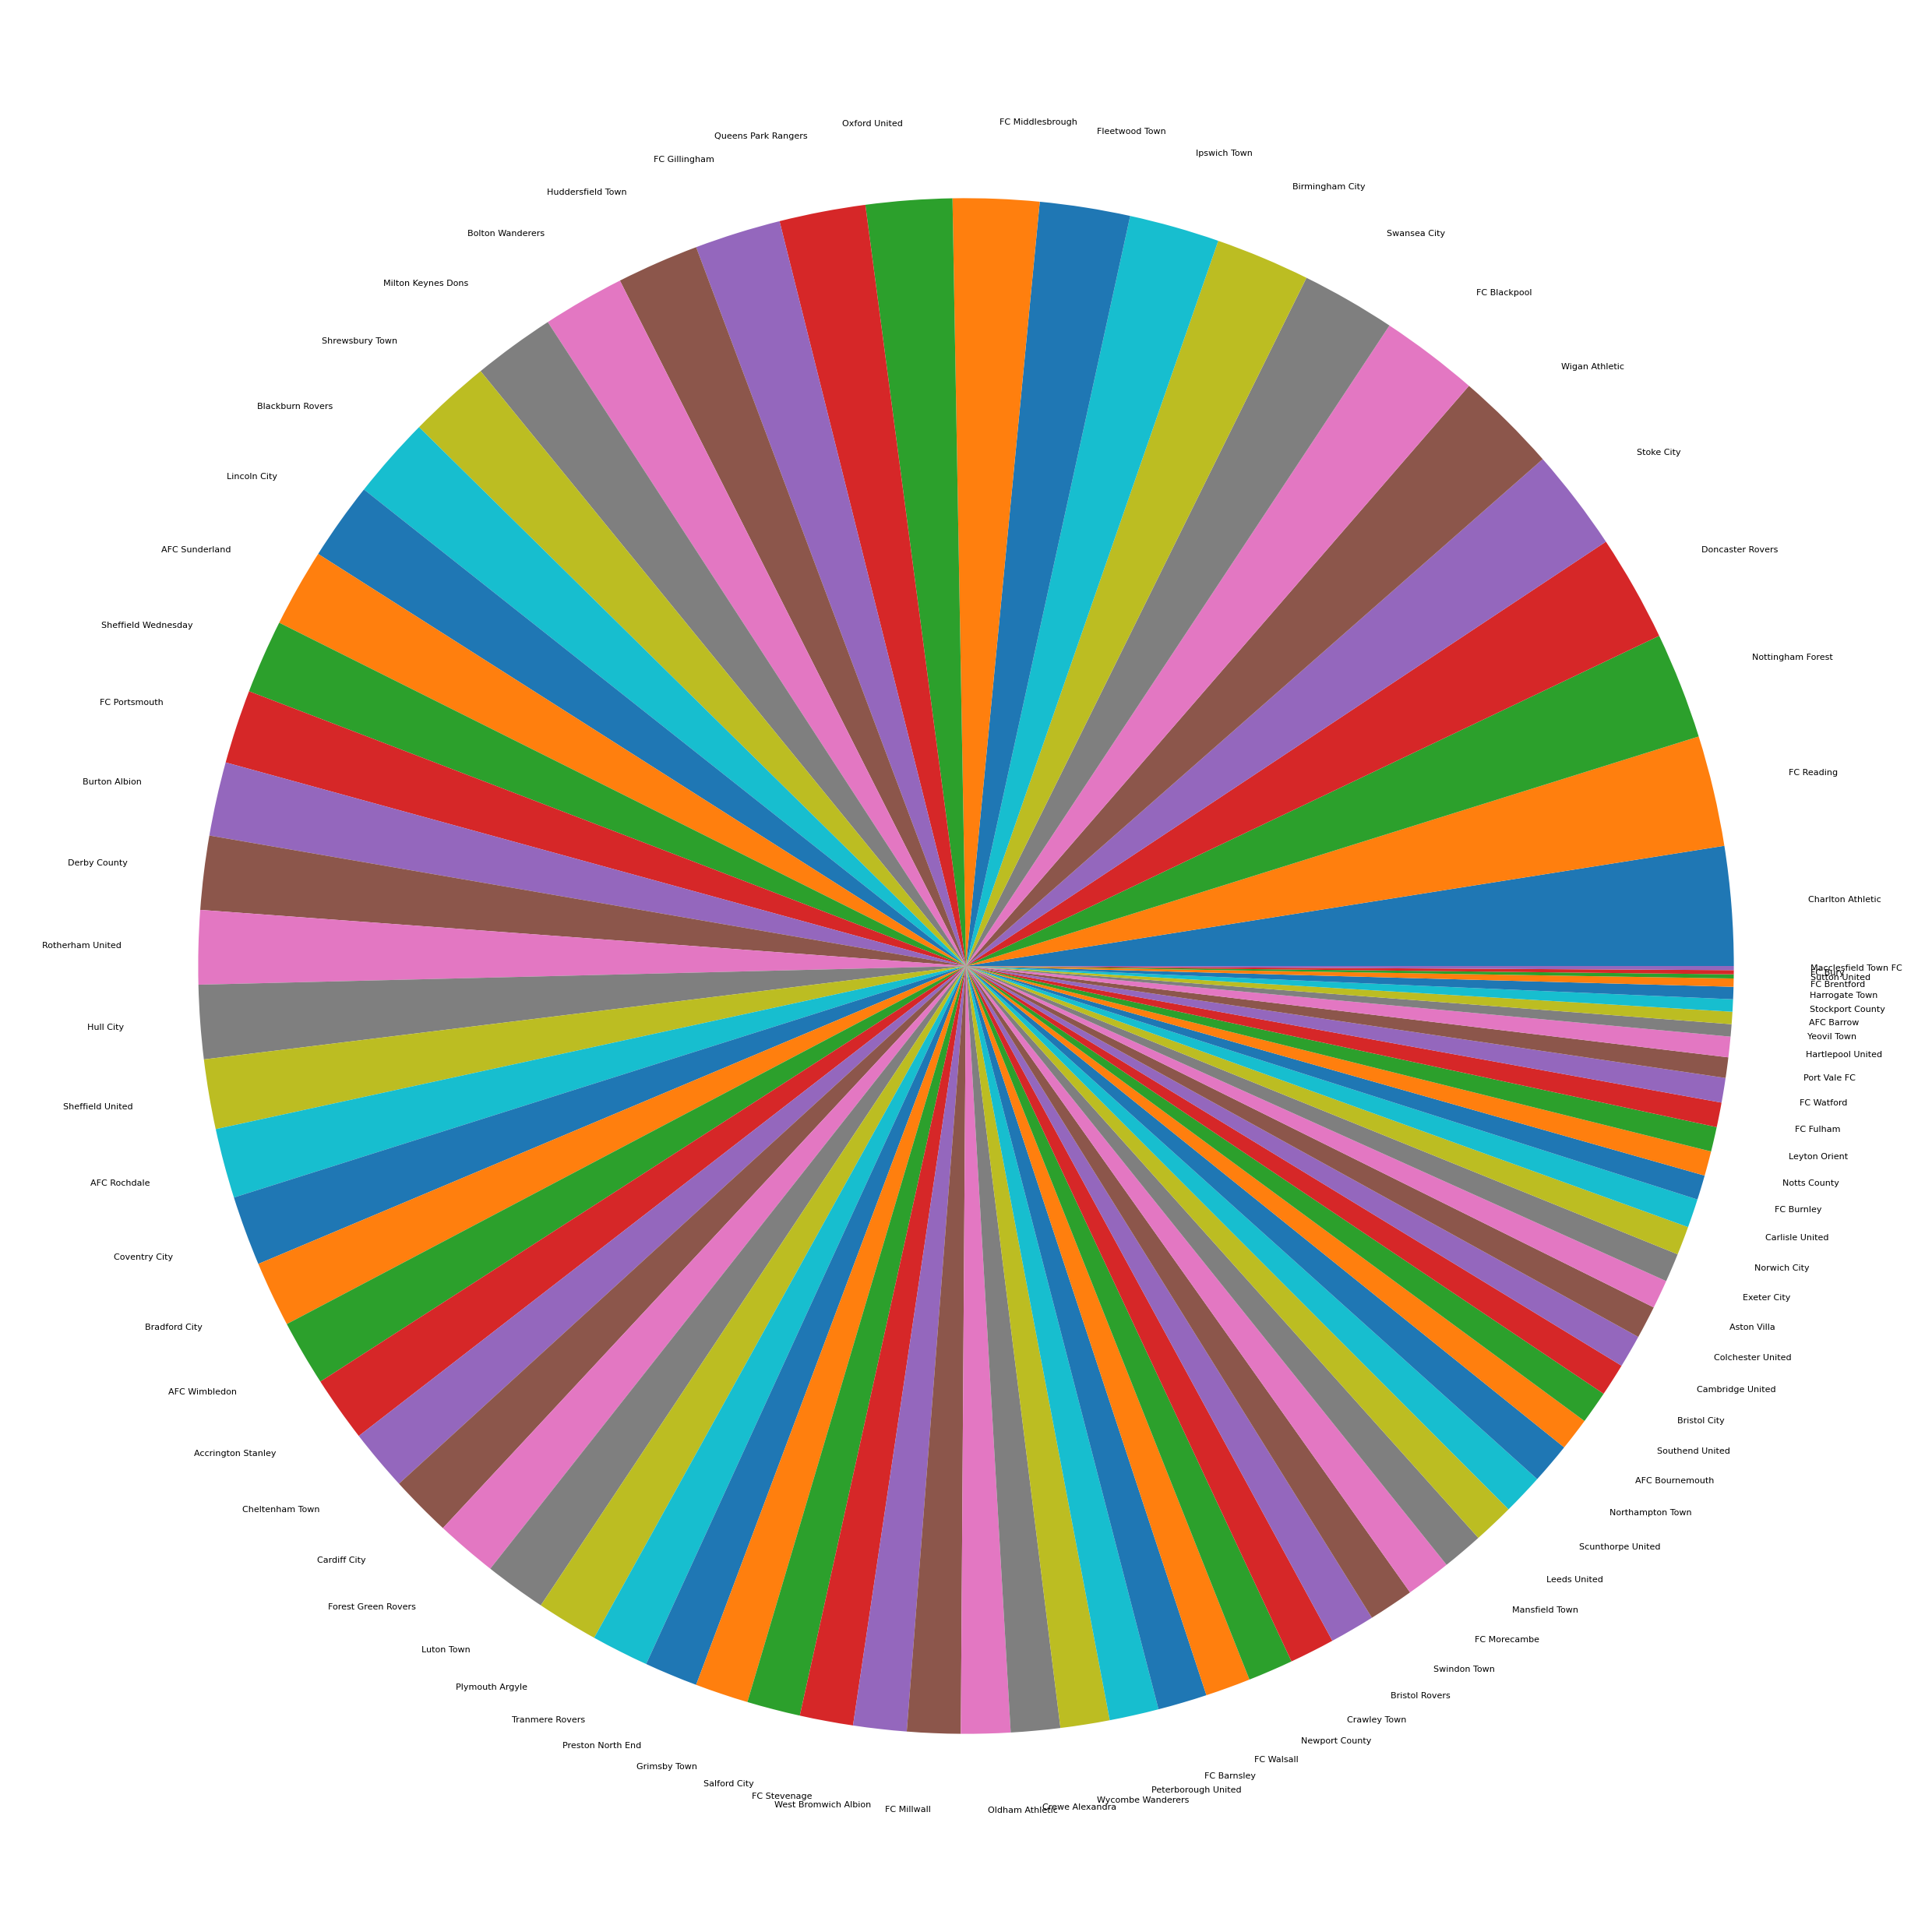

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unique loaning clubs
unique_clubs = final_df['loaning_club'].unique()
print(f"In given period {len(unique_clubs)} clubs has loaned in player")

#Loans for every given club
loans_number = final_df['loaning_club'].value_counts()
plt.figure(figsize=(40,40), dpi = 80)
plt.pie(loans_number, labels=loans_number.index)
loans_number

In [63]:
"""page = "https://www.transfermarkt.pl/manchester-united/startseite/verein/985"
treeSoup = requests.get(page, headers=headers)
pageSoup = BeautifulSoup(treeSoup.content, 'html.parser')
print(pageSoup)
gracze = []
gracze = pageSoup.find_all("img", {"class": "bilderrahmen-fixed lazy lazy"})
gracze"""

'page = "https://www.transfermarkt.pl/manchester-united/startseite/verein/985"\ntreeSoup = requests.get(page, headers=headers)\npageSoup = BeautifulSoup(treeSoup.content, \'html.parser\')\nprint(pageSoup)\ngracze = []\ngracze = pageSoup.find_all("img", {"class": "bilderrahmen-fixed lazy lazy"})\ngracze'